# Simulation analysis - final paramaters
## Saturn Aliens

### Maria Silva, October 2022

In this simulation, we run a single anlaysis on the final set of parameters (with an updated pot of FIL and growth baseline function)

In [1]:
import os
import sys
import tqdm
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('../src/'))
from treasury_sim.sim_v2 import run_single_sim
from treasury_sim import metrics

import warnings
warnings.filterwarnings('ignore')

## 1. Design details 

Note that for this simulation we are focussing on the L1 node operators and their payouts. 

* **Operator types (performance distribution will be based out of real data!):**
    * Honest high-performing L1 operator (10%)
    * Honest average L1 operator (75%)
    * Honest low-performing L1 operator (10%)
    * Cheating L1 operator (5%)
* **Simulation forecast:** 12 months
* **Simulation parameters:**
    * Log detection performance:
        * FPR: 1%
        * Recall 25%
    * Penalty size: 5x average reward
    * Payout frequency: Once per day
    * Scoring functions
        * Direct multiplication
        * Bandwidth exponent: $k_1 = 0.5$
        * Uptime and speed exponents: $k_2 = 2$
    * Initial reward pool investment: 4M/yr (800k fil/yr at $5/fil)
    * Initial set of operators: 10
    * New operators' inflow (i.e. new operators entering the network): 1 (goal of 100-400 operators after 12 months)

**Define parameters**

In [2]:
n_months = 12
sim_len = n_months * 30 
initial_ops_num = 10
new_ops_num = 1
total_pool = 800000 # $4M/yr (800k fil/yr at $5/fil)
is_growth_pool = True
k1=0.5
k2=2.0
penalty_mult=5.0

## 2. Run simulation

In [3]:
n_iter = 100
raw_sim_df = pd.DataFrame()
raw_traj_df = pd.DataFrame()

for i in tqdm.tqdm(range(n_iter)):
    ops_list = run_single_sim(sim_len, k1, k2, penalty_mult, [], initial_ops_num, new_ops_num, is_growth_pool, total_pool)
    iter_sim_df = metrics.compute_sim_metrics(ops_list, k1=k1, k2=k2, penalty_multiplier=penalty_mult)
    iter_sim_df["iter"] = i
    raw_sim_df = pd.concat([raw_sim_df, iter_sim_df], ignore_index=True)
    iter_traj_df = metrics.compute_ops_trajectory(ops_list, sim_len, k1=k1, k2=k2, penalty_multiplier=penalty_mult)
    iter_traj_df["iter"] = i
    raw_traj_df = pd.concat([raw_traj_df, iter_traj_df], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]


**Quick data processing**

In [4]:
# Process sim stats
sim_df = raw_sim_df
sim_df["Operator type"] = sim_df["op_type"].replace({"honest_low_l1": "Low perf.",
                                                          "honest_normal_l1": "Normal perf.",
                                                          "cheating_l1": "Cheating",
                                                          "honest_high_l1": "High perf."})
sim_df["penalty_ratio"] = sim_df["total_penalty"]/(sim_df["total_penalty"]+sim_df["total_payout"])
sim_df["penalty_ratio"] = sim_df["penalty_ratio"].fillna(0)
sim_df.head()

,op_type,num_payouts,missed_payouts,total_payout,avg_payout,median_payout,total_penalty,num_penalties,avg_penalty,max_no_penalty_period,collateral_balance,total_bandwidth,k1,k2,penalty_multiplier,iter,Operator type,penalty_ratio
0,honest_low_l1,356,4,832.872991,2.339531,2.440320,0.000000,0,0.000000,360,11.730606,216.300631,0.5,2.0,5.0,0,Low perf.,0.000000
1,honest_normal_l1,331,29,3747.186143,11.320804,11.885546,325.255930,6,54.209322,104,57.358339,322.796675,0.5,2.0,5.0,0,Normal perf.,0.079868
2,honest_high_l1,344,16,5599.538675,16.277729,17.061434,214.636331,3,71.545444,166,81.889789,431.754157,0.5,2.0,5.0,0,High perf.,0.036916
3,honest_high_l1,335,25,5444.206987,16.251364,16.947773,365.834463,5,73.166893,89,81.831570,431.238821,0.5,2.0,5.0,0,High perf.,0.062966
4,honest_normal_l1,352,8,4032.804376,11.456831,11.966819,47.397911,1,47.397911,268,57.467638,324.111084,0.5,2.0,5.0,0,Normal perf.,0.011617


In [5]:
# Process traj data
traj_df = raw_traj_df
traj_df["sim_step"] = traj_df["sim_step"].astype(int)
traj_df["payout"] = traj_df["payout"].astype(float)
traj_df["penalty"] = traj_df["penalty"].astype(float)
traj_df["flag"] = traj_df["flag"].astype(bool)
traj_df["Operator type"] = traj_df["op_type"].replace({"honest_low_l1": "Low perf.",
                                                       "honest_normal_l1": "Normal perf.",
                                                       "cheating_l1": "Cheating",
                                                       "honest_high_l1": "High perf."})

traj_df.head()

,sim_step,op_type,payout,flag,penalty,bandwidth,k1,k2,penalty_multiplier,iter,Operator type
0,0,honest_low_l1,0.000000e+00,False,0.0,0.617725,0.5,2.0,5.0,0,Low perf.
1,1,honest_low_l1,0.000000e+00,False,0.0,0.611748,0.5,2.0,5.0,0,Low perf.
2,2,honest_low_l1,0.000000e+00,False,0.0,0.574940,0.5,2.0,5.0,0,Low perf.
3,3,honest_low_l1,0.000000e+00,False,0.0,0.652262,0.5,2.0,5.0,0,Low perf.
4,4,honest_low_l1,1.110223e-16,False,0.0,0.589073,0.5,2.0,5.0,0,Low perf.


In [6]:
sum_traj_df = (traj_df
               .groupby(["sim_step", "iter"])
               .sum()
               .reset_index()
              )
sum_traj_df.head()

,sim_step,iter,payout,flag,penalty,bandwidth,k1,k2,penalty_multiplier
0,0,0,0.0,0,0.0,8.814900,5.0,20.0,50.0
1,0,1,0.0,1,0.0,9.278583,5.0,20.0,50.0
2,0,2,0.0,0,0.0,10.131315,5.0,20.0,50.0
3,0,3,0.0,0,0.0,8.813362,5.0,20.0,50.0
4,0,4,0.0,0,0.0,9.487514,5.0,20.0,50.0


**Define op types pallete**

In [7]:
palette_colors = sns.color_palette('Set2', n_colors=4)
ops_types = ['Low perf.', 'Normal perf.', 'High perf.', 'Cheating']
op_types_palette = {op_type: color for op_type, color in zip(ops_types, palette_colors)}

## 3. Capital deployment

Let's explore to see how capital is deployed and how it flows to the participants.

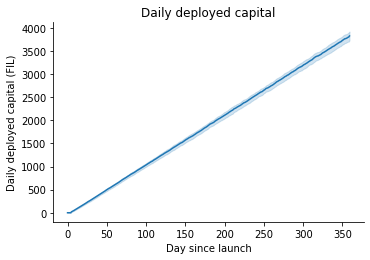

In [8]:
g = sns.relplot(x="sim_step", y="payout", data=sum_traj_df, kind="line", aspect=1.5, height=3.5, ci="sd")
g.set_axis_labels("Day since launch", "Daily deployed capital (FIL)")
plt.title('Daily deployed capital')
plt.show()

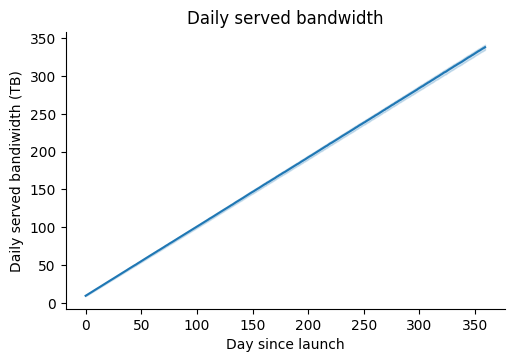

In [9]:
g = sns.relplot(x="sim_step", y="bandwidth", data=sum_traj_df, kind="line", aspect=1.5, height=3.5, ci="sd")
g.set_axis_labels("Day since launch", "Daily served bandiwidth (TB)")
plt.title('Daily served bandwidth')
plt.show()

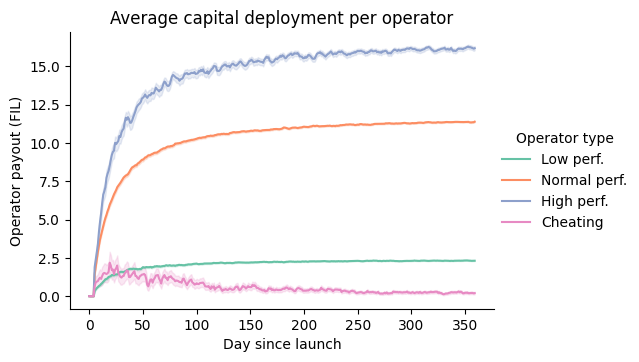

In [10]:
g = sns.relplot(x="sim_step", y="payout", hue="Operator type", data=traj_df, 
                aspect=1.5, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("Day since launch", "Operator payout (FIL)")
plt.title('Average capital deployment per operator')
plt.show()

**Total deployed capital and total penalties:**

In [11]:
total_df = sum_traj_df.groupby("iter")[["penalty", "payout"]].sum()
total_df["total_pool"] = total_df["penalty"]+total_df["payout"]
total_df["capital_loss_ratio"] = total_df["penalty"]/total_df["total_pool"]
total_df.agg(["mean", "std"])

,penalty,payout,total_pool,capital_loss_ratio
mean,108984.107373,681445.426657,790429.534029,0.137761
std,19059.055609,15115.892898,4423.445870,0.023427


## 4. Capital distribution among honest operators

Now, we explore how capital is being distributed among honest operators and how the different scoring functions impact that distribution. We also look into penalties and how the log detection system and penalty multiplier impacts the rewards received by honest operators.

In [12]:
honest_sim_df = sim_df[sim_df["op_type"] != "cheating_l1"]

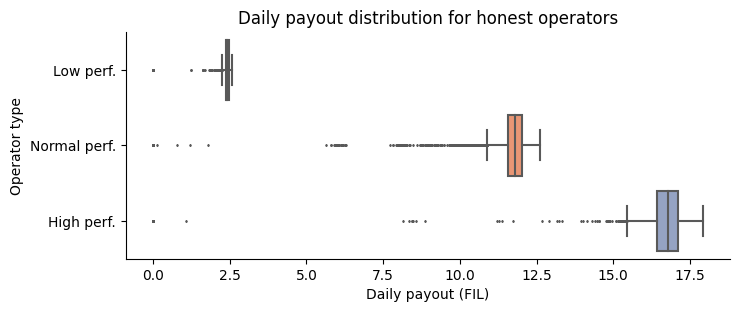

In [13]:
g = sns.catplot(y="Operator type", x="avg_payout", kind="box", aspect=2.5, height=3, 
                data=honest_sim_df, fliersize=1, palette=op_types_palette)
g.set_axis_labels("Daily payout (FIL)", "Operator type")
plt.title('Daily payout distribution for honest operators')
plt.show()

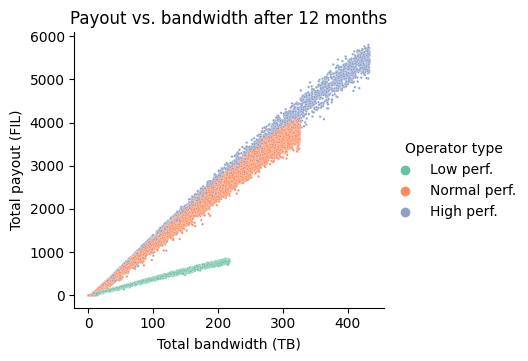

In [14]:
g = sns.relplot(x="total_bandwidth", y="total_payout", hue="Operator type",
                height=3.5, aspect=1.2, data=honest_sim_df, kind="scatter", s=3, palette=op_types_palette)
g.set_axis_labels("Total bandwidth (TB)", "Total payout (FIL)")
plt.title('Payout vs. bandwidth after 12 months')
plt.show()

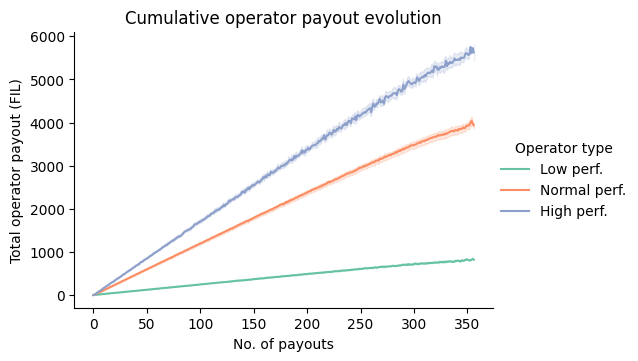

In [15]:
g = sns.relplot(x="num_payouts", y="total_payout", hue="Operator type",ci="sd",
                data=honest_sim_df, aspect=1.5, height=3.5, kind="line", palette=op_types_palette)
g.set_axis_labels("No. of payouts", "Total operator payout (FIL)")
plt.title('Cumulative operator payout evolution')
plt.show()

## 5. Penalties and value extracted by cheating operators

Finally, we focus on the cheating operators and analyze how much value they extract from the network. We also analyze penalties applied to honest nodes

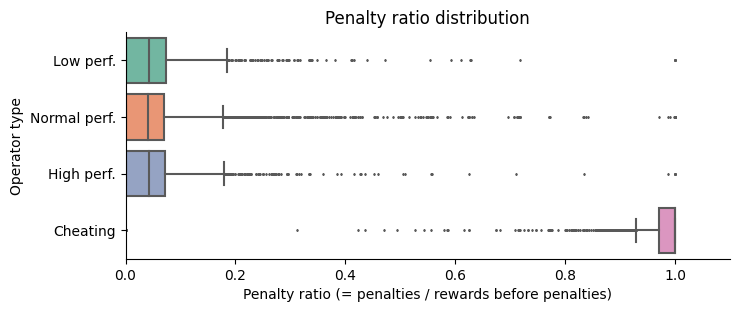

In [16]:
g = sns.catplot(y="Operator type", x="penalty_ratio", data=sim_df,kind="box",
                aspect=2.5, height=3, fliersize=1, palette=op_types_palette)
g.set(xlim=(0, 1.1))
g.set_axis_labels("Penalty ratio (= penalties / rewards before penalties)", "Operator type")
plt.title('Penalty ratio distribution')
plt.show()

**Percentage of cheating nodes that get paid**

In [17]:
cheat_sim_df = sim_df[sim_df["op_type"] == "cheating_l1"]
cheat_sim_df.loc[:,"Got paid"] = np.where(cheat_sim_df["num_payouts"]>0, "Yes", "No")

paid_df = cheat_sim_df.groupby(["Got paid", "iter"]).size()
paid_df = paid_df["Yes"]/(paid_df["Yes"]+paid_df["No"])

paid_df.agg(["mean", "std"])

mean    0.512521
std     0.105424
dtype: float64

**Value extracted by cheating nodes**

In [18]:
cheat_sum_df = (
    cheat_sim_df
    .groupby(["iter"])
    [["total_payout", "total_penalty"]]
    .sum()
)
cheat_sum_df["count"] = cheat_sim_df.groupby(["iter"]).size()
cheat_sum_df["avg_payout"] = cheat_sum_df["total_payout"] / cheat_sum_df["count"] 

cheat_sum_df.agg(["mean", "std"])

,total_payout,total_penalty,count,avg_payout
mean,1419.061336,73461.712764,19.500000,71.936718
std,756.406269,19979.424100,5.155168,31.674589
